In [172]:
import networkx as nx

from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.aws import AwsDevice

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.field import Field
from braket.devices import LocalSimulator
from braket.ahs.hamiltonian import Hamiltonian

import matplotlib.pyplot as plt
import time
import numpy as np

from collections import Counter

In [173]:
# constants
atoms_w = 4
atoms_l = 4
num_graphs = 5

In [174]:
def generate_unit_disk(atoms_l: int, atoms_w: int, scale=4.0*1e-6, dropout=0.45, seed=seed):
    while True: 
        atom_list = []
        edge_dict = {}
        atom_to_edge = {}

        for ii in range(atoms_l):
            for jj in range(atoms_w):
                atom_list.append((ii * scale, jj * scale))
                atom_to_edge[(ii * scale, jj * scale)] = ii * atoms_w + jj
                edge_dict[ii * atoms_w + jj] = []

                if jj < atoms_w - 1:
                    edge_dict[ii * atoms_w + jj].append(ii * atoms_w + jj + 1)
                if ii < atoms_l - 1:
                    edge_dict[ii * atoms_w + jj].append((ii + 1) * atoms_w + jj)

                if ii < atoms_l - 1 and jj < atoms_w - 1:
                    edge_dict[ii * atoms_w + jj].append((ii + 1) * atoms_w + jj + 1)
                if jj > 0 and ii < atoms_l - 1:
                    edge_dict[ii * atoms_w + jj].append((ii + 1) * atoms_w + jj - 1)

        graph = nx.from_dict_of_lists(edge_dict)

        new_len = int(np.round(len(atom_list) * (1 - dropout)))
        atom_arr = np.empty(len(atom_list), dtype=object)
        atom_arr[:] = atom_list
        remaining_atom_list = np.random.choice(atom_arr, new_len, replace=False)

        atoms = AtomArrangement()
        for atom in remaining_atom_list:
            atoms.add(atom)

        graph.remove_nodes_from([atom_to_edge[atom] for atom in set(atom_list) - set(list(remaining_atom_list))])

        if nx.is_connected(graph):
            return atoms, graph 

In [191]:
def is_independent_set(graph, state):
    state_map = {node: state[i] for i, node in enumerate(graph.nodes)}
    for node in graph.nodes:
        if state_map[node] == 'r':  
            for neighbor in graph.neighbors(node):
                if state_map.get(neighbor) == 'r':
                    return False  
    return True

In [176]:
def loss_piecewise_linear(atoms: AtomArrangement, T_flat: float, T_max: float, T_rise: float, Omega_max: float, Delta_max: float, shots=5000):
  
    Delta_start = -Delta_max
    Delta_end = Delta_max

    time_points = [ 0.0, T_flat, T_flat + T_rise, T_max - T_flat - T_rise, T_max - T_flat, T_max ]

    Deltas = TimeSeries()
    Deltas.put(time_points[0], Delta_start)
    Deltas.put(time_points[1], Delta_start)
    Deltas.put(time_points[4], Delta_end)
    Deltas.put(time_points[5], Delta_end)

    Omegas = TimeSeries()
    Omegas.put(time_points[0], 0.0)
    Omegas.put(time_points[1], 0.0)
    Omegas.put(time_points[2], Omega_max)
    Omegas.put(time_points[3], Omega_max)
    Omegas.put(time_points[4], 0.0)
    Omegas.put(time_points[5], 0.0)
    

    Phi = TimeSeries()
    Phi.put(time_points[0], 0.0)
    Phi.put(time_points[5], 0.0)

    H = DrivingField(amplitude=Omegas, phase=Phi, detuning=Deltas)

    program = AnalogHamiltonianSimulation(hamiltonian=H, register=atoms)
    device = LocalSimulator("braket_ahs")

    results = device.run(program, shots=shots, steps=100).result()

    r_counts = []

    states = ['e', 'r', 'g']
    for shot in results.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state_labels = [states[s_idx] for s_idx in state_idx]
        r_count = np.count_nonzero([sl == 'r' for sl in state_labels]) / len(atoms)
        r_counts.append(r_count)

    density_sum = np.mean(r_counts)
    density_std = np.std(r_counts)

    return density_sum, density_std, results

In [177]:
# parameters
T_flat = 0.1*1e-6
T_max = 0.6*1e-6

Omega_values = np.linspace(-20 * 2 * np.pi * 1e6, 20 * 2 * np.pi * 1e6, 500) 
Delta_values = np.linspace(-20 * 2 * np.pi * 1e6, 20 * 2 * np.pi * 1e6, 500)
T_rise_values = np.linspace(0, 0.5e-6, 500)

seed_number = 92

start = time.time()
initial_rydberg_density, initial_density_std, initial_registers = loss_piecewise_linear(atoms, T_flat, T_max, T_rise, Omega_max, Delta_max)
print(f"Initial density: {initial_rydberg_density}, Standard deviation: {initial_density_std}")
stop = time.time()
print(f"Time to run AHS with local simulator: {stop-start}")

Initial density: 0.3449777777777778, Standard deviation: 0.04906747181303982
Time to run AHS with local simulator: 2.686737298965454


Graph 1 - Initial density: 0.4115111111111111, Standard deviation: 0.059436348358330685
Graph 2 - Initial density: 0.3712888888888889, Standard deviation: 0.07077258309909648
Graph 3 - Initial density: 0.38602222222222227, Standard deviation: 0.07077475660741975
Graph 4 - Initial density: 0.35708888888888896, Standard deviation: 0.07101465333052272
Graph 5 - Initial density: 0.34422222222222226, Standard deviation: 0.050478696154240145


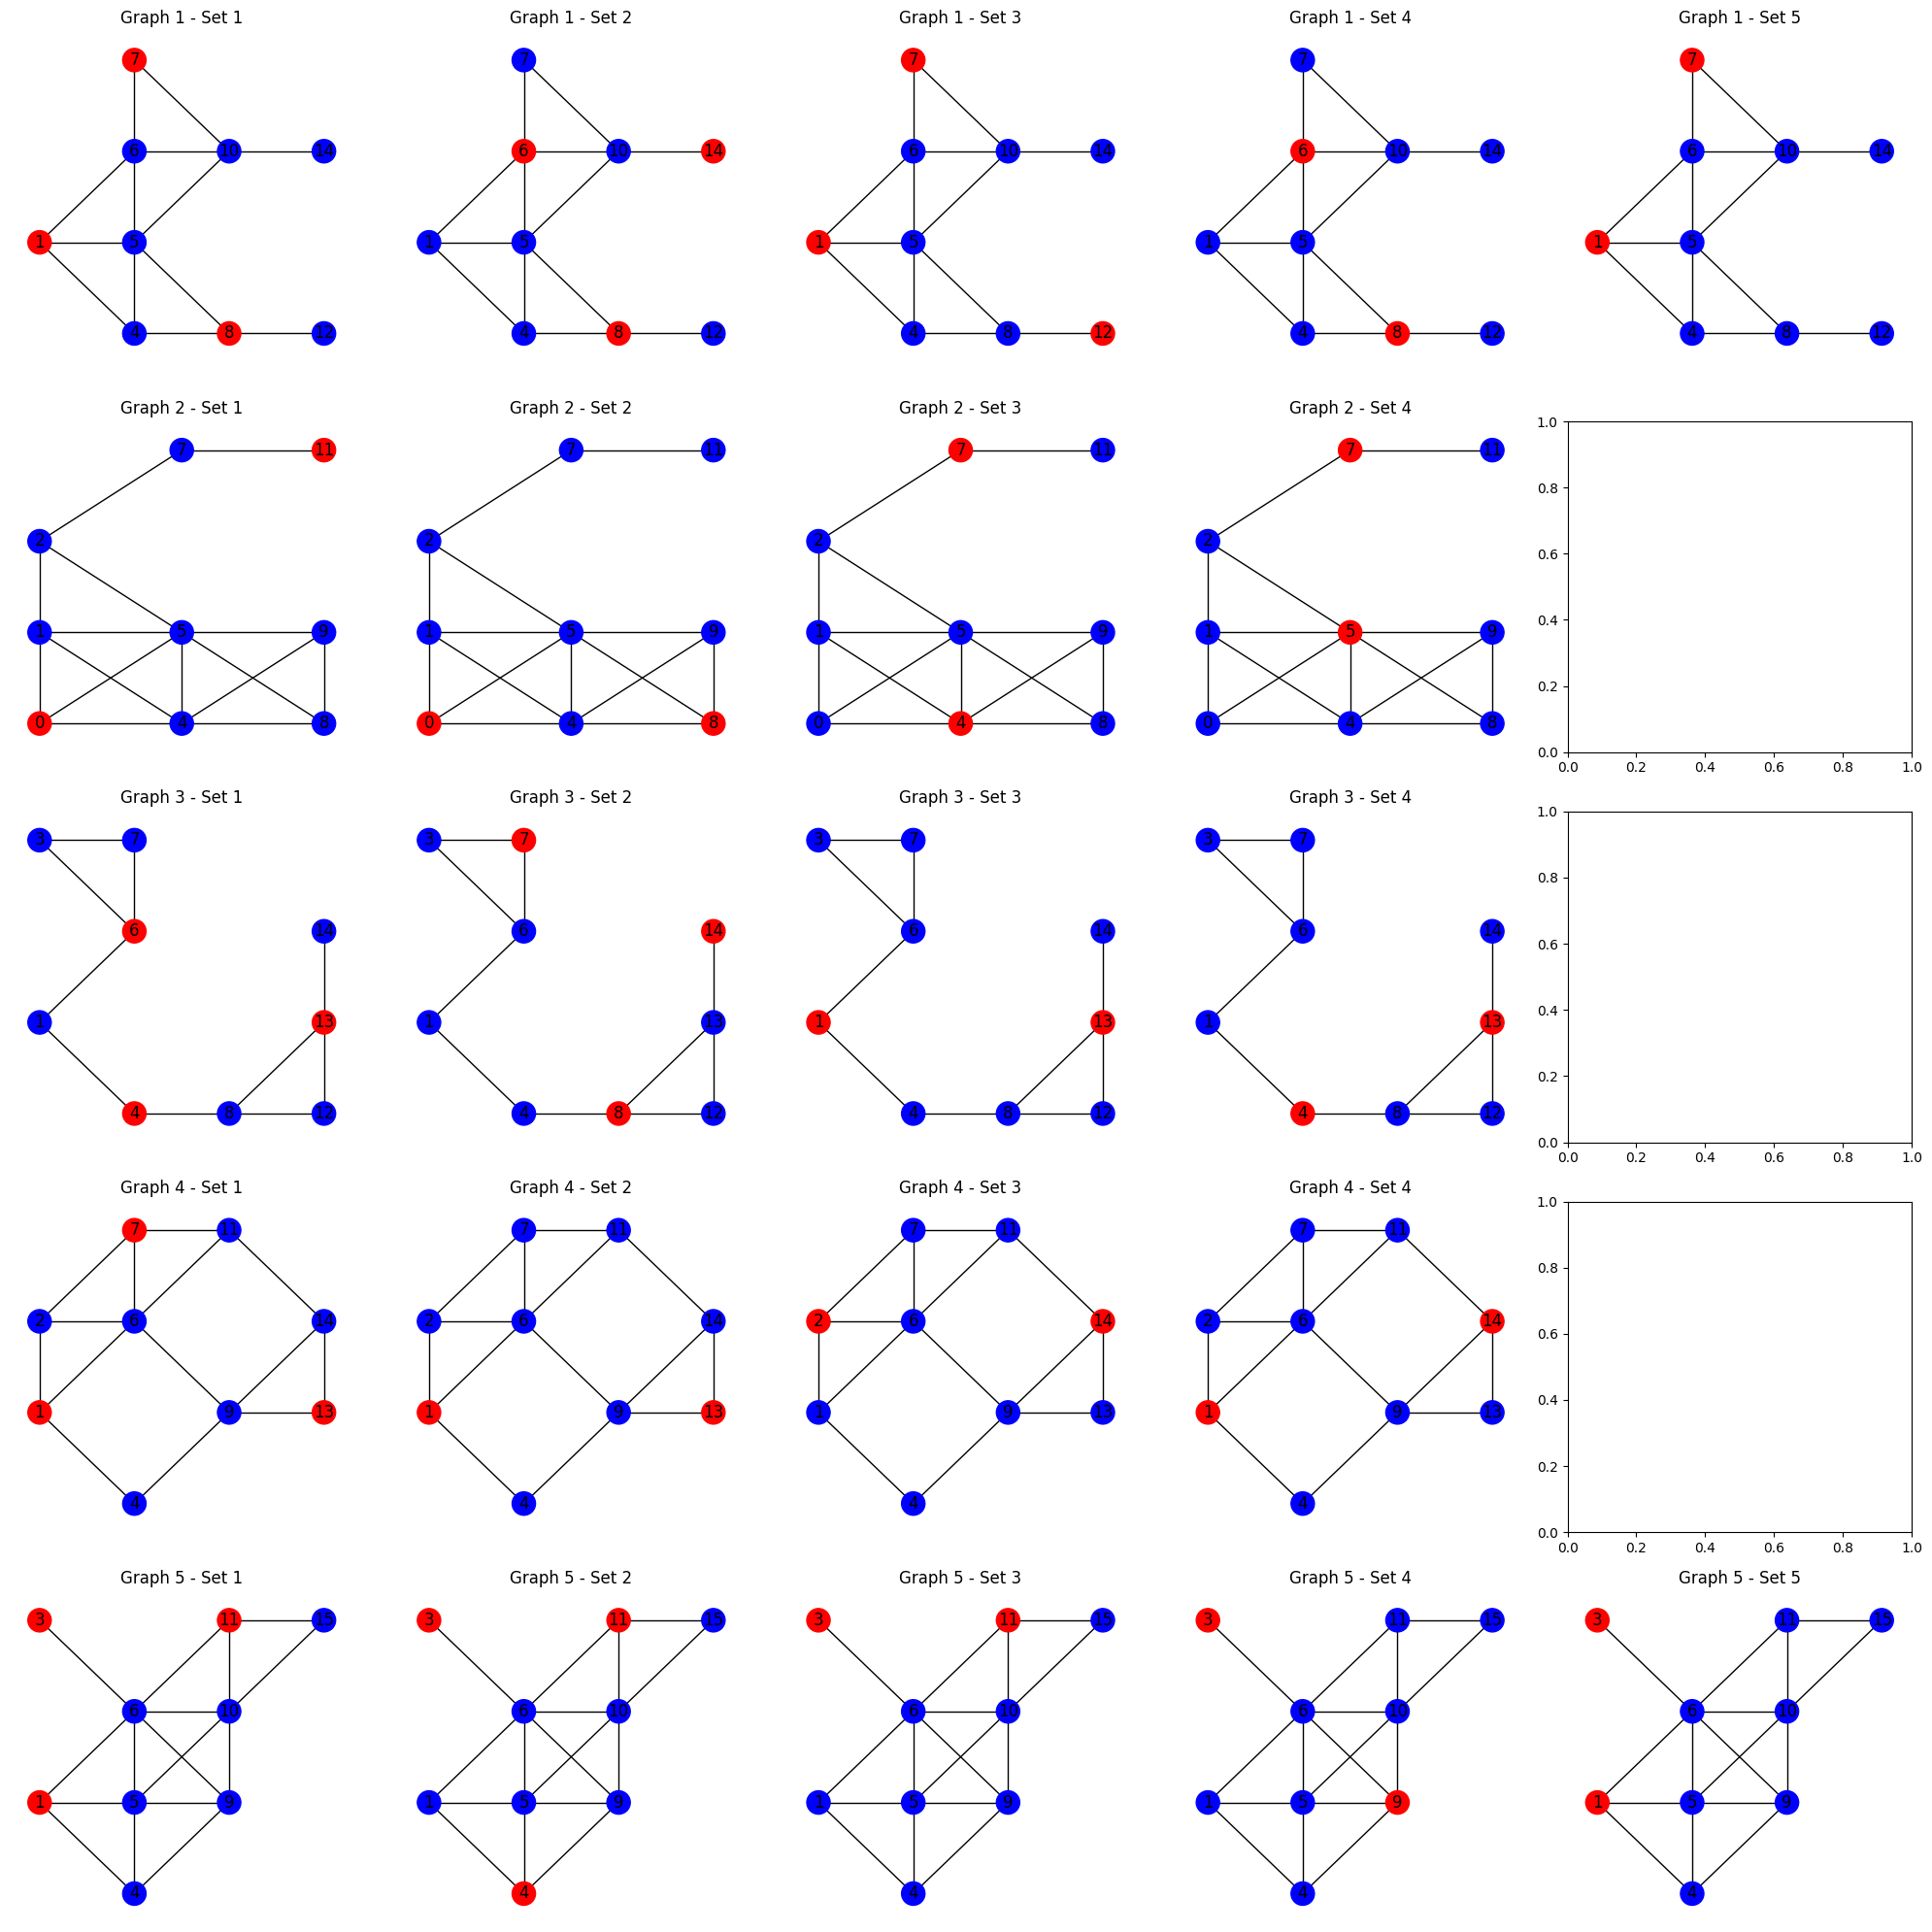

In [178]:
np.random.seed(seed_number)

graphs = []
for graph_idx in range(num_graphs):
    seed = np.random.randint(0, 100000)  
    np.random.seed(seed)  
    atoms, graph = generate_unit_disk(atoms_l, atoms_w, seed=seed)
    graphs.append((atoms, graph))

fig, axs = plt.subplots(num_graphs, 5, figsize=(20, 4 * num_graphs))

for i, (atoms, graph) in enumerate(graphs):
    initial_rydberg_density, initial_density_std, initial_registers = loss_piecewise_linear(
        atoms, T_flat=0.1 * 1e-6, T_max=0.6 * 1e-6, T_rise=0.05 * 1e-6, Omega_max=4 * 2 * np.pi * 1e6, Delta_max=11 * 2 * np.pi * 1e6
    )
    print(f"Graph {i + 1} - Initial density: {initial_rydberg_density}, Standard deviation: {initial_density_std}")

    states = ['e', 'r', 'g']
    state_labels = []
    for shot in initial_registers.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state_labels.append("".join([states[s_idx] for s_idx in state_idx]))

    occurrence_count = Counter(state_labels)
    most_frequent_regs = occurrence_count.most_common(20)

    valid_solutions = []
    for state, count in most_frequent_regs:
        if len(valid_solutions) >= 5:
            break
        if is_independent_set(graph, state):
            valid_solutions.append((state, count))

    for j, (state, count) in enumerate(valid_solutions):
        ax = axs[i, j]
        vert_colors = ['red' if (state[k] == 'r') else 'blue' for k in range(len(state))]
        pos = {ii: (ii // atoms_w, ii % atoms_w) for ii in graph.nodes()}
        nx.draw(graph, pos=pos, ax=ax, with_labels=True, node_color=vert_colors)
        ax.set_title(f"Graph {i + 1} - Set {j + 1}")

plt.tight_layout()
plt.show()

In [179]:
def evaluate_mean(parameter_values, parameter_name):
    mean_results = []  

    for param in parameter_values:
        densities_per_graph = []  
        for atoms, graph in graphs:

            Omega_max = 4 * 2 * np.pi * 1e6 if parameter_name != "Omega" else param
            Delta_max = 11 * 2 * np.pi * 1e6 if parameter_name != "Delta" else param
            T_rise = 0.05 * 1e-6 if parameter_name != "T_rise" else param

            density, _, _ = loss_piecewise_linear(atoms, T_flat=0.1 * 1e-6, T_max=0.6 * 1e-6, T_rise=T_rise, Omega_max=Omega_max, Delta_max=Delta_max)
            densities_per_graph.append(density)  

        mean_density = np.mean(densities_per_graph)
        mean_results.append(mean_density)
    
    return parameter_values, mean_results


In [183]:
def evaluate_std(parameter_values, parameter_name):
    std_results = []

    for param in parameter_values:
        densities_per_graph = []  
        for atoms, graph in graphs:

            Omega_max = 4 * 2 * np.pi * 1e6 if parameter_name != "Omega" else param
            Delta_max = 11 * 2 * np.pi * 1e6 if parameter_name != "Delta" else param
            T_rise = 0.05 * 1e-6 if parameter_name != "T_rise" else param

            density, _, _ = loss_piecewise_linear(atoms, T_flat=0.1 * 1e-6, T_max=0.6 * 1e-6, T_rise=T_rise, Omega_max=Omega_max, Delta_max=Delta_max)
            densities_per_graph.append(density)

        std_dev_density = np.std(densities_per_graph)
        std_results.append(std_dev_density)
    
    return parameter_values, std_results


In [181]:
omega_vals, omega_densities = evaluate_mean(Omega_values, "Omega")
delta_vals, delta_densities = evaluate_mean(Delta_values, "Delta")
t_rise_vals, t_rise_densities = evaluate_mean(T_rise_values, "T_rise")

In [187]:
omega_vals, omega_std_devs = evaluate_std(Omega_values, "Omega")
delta_vals, delta_std_devs = evaluate_std(Delta_values, "Delta")
t_rise_vals, t_rise_std_devs = evaluate_std(T_rise_values, "T_rise")

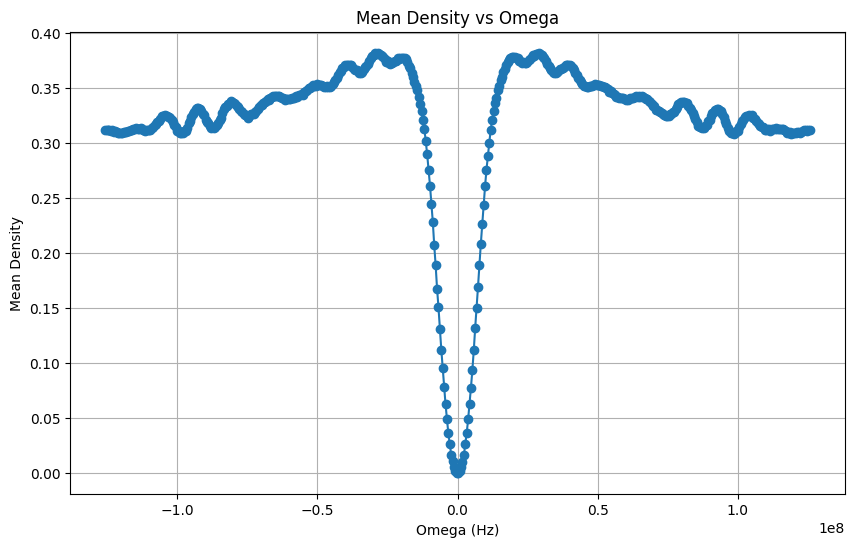

In [184]:
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, omega_densities, marker='o')
plt.xlabel('Omega (Hz)')
plt.ylabel('Mean Density')
plt.title('Mean Density vs Omega')
plt.grid(True)
plt.show()

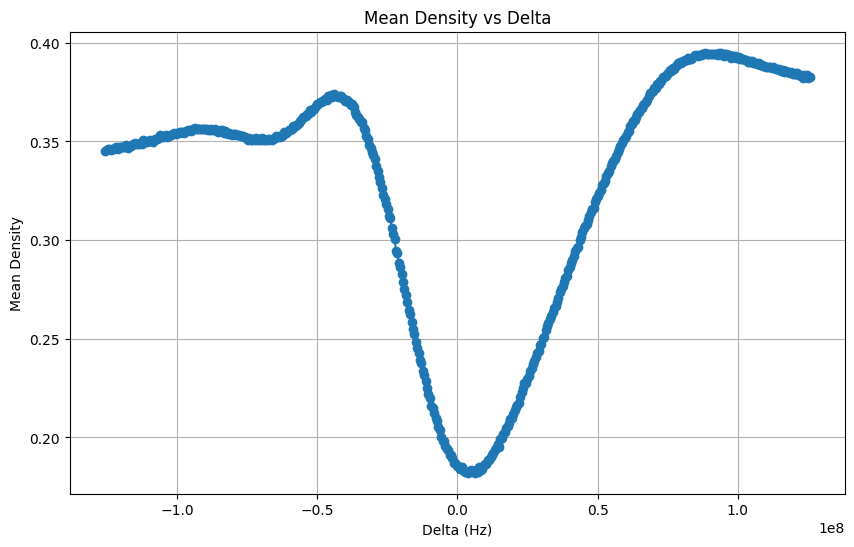

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(delta_vals, delta_densities, marker='o')
plt.xlabel('Delta (Hz)')
plt.ylabel('Mean Density')
plt.title('Mean Density vs Delta')
plt.grid(True)
plt.show()

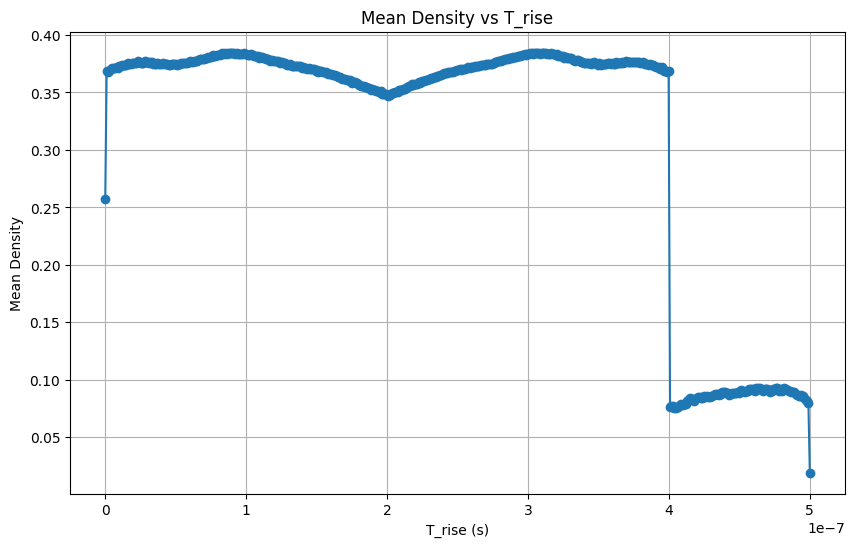

In [186]:
plt.figure(figsize=(10, 6))
plt.plot(t_rise_vals, t_rise_densities, marker='o')
plt.xlabel('T_rise (s)')
plt.ylabel('Mean Density')
plt.title('Mean Density vs T_rise')
plt.grid(True)
plt.show()

/var/folders/7q/c79yt8xj4939zd73q_l9lqth0000gn/T/ipykernel_56547/1800947018.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


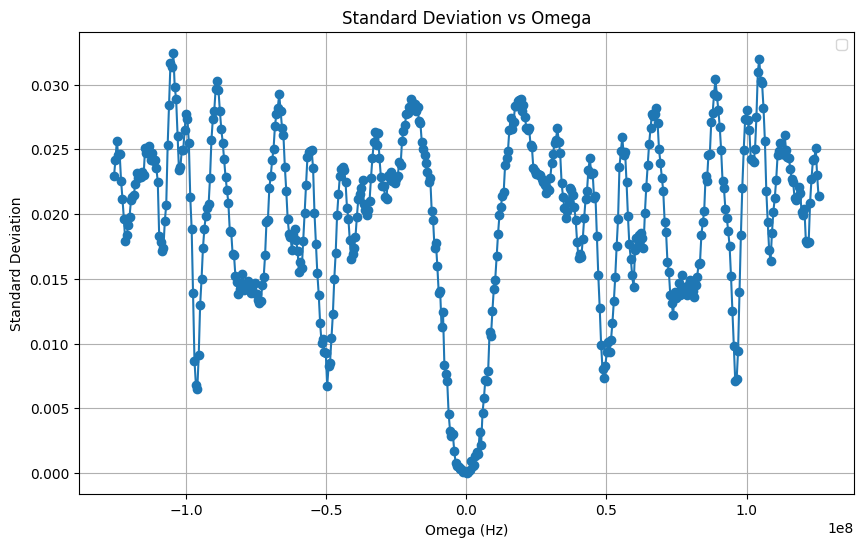

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, omega_std_devs, marker='o')
plt.xlabel('Omega (Hz)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Omega')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/7q/c79yt8xj4939zd73q_l9lqth0000gn/T/ipykernel_56547/2025057283.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


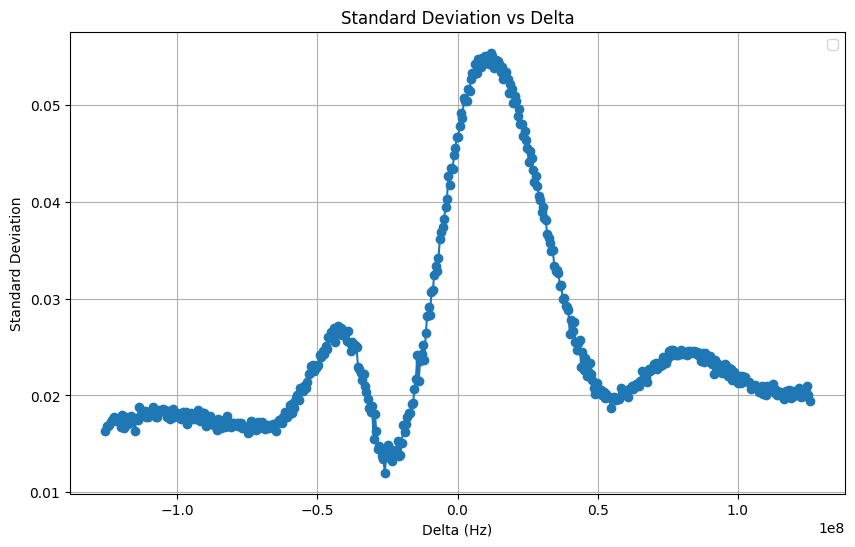

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(delta_vals, delta_std_devs, marker='o')
plt.xlabel('Delta (Hz)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Delta')
plt.legend()
plt.grid(True)
plt.show()

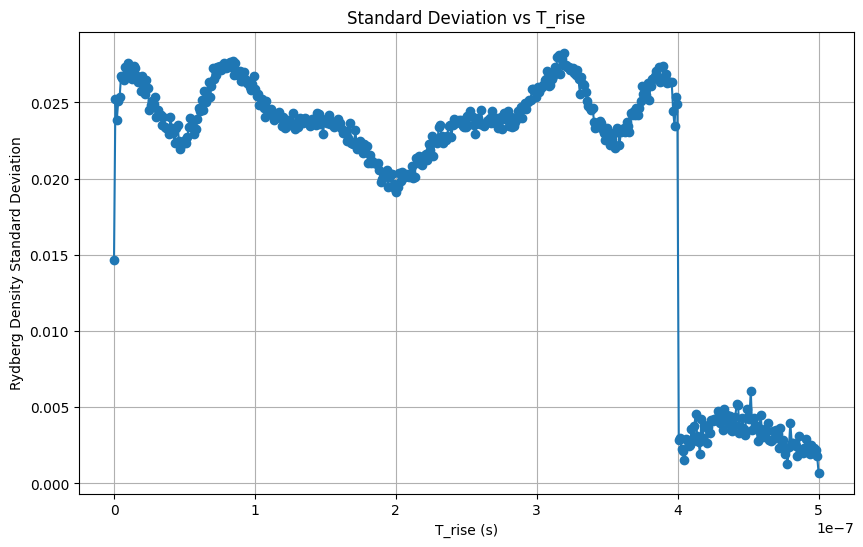

In [190]:
plt.figure(figsize=(10, 6))
plt.plot(t_rise_vals, t_rise_std_devs, marker='o')
plt.xlabel('T_rise (s)')
plt.ylabel('Rydberg Density Standard Deviation')
plt.title('Standard Deviation vs T_rise')
plt.grid(True)
plt.show()